In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model, Model, Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Input, SimpleRNN, LSTM, Dense,Dropout, Activation , Flatten, ConvLSTM2D, Conv2D, Reshape, TimeDistributed, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
import keras

In [49]:
#Ubicación de los archivos

path = r"/Users/javier/Documents/Data/"   
path2 = r"/Users/javier/Downloads/"


#dswind= xr.open_dataset(path + 'download(2000-2009).nc') # set de presión

names = ['download(1979-1988).nc',
         'download(1989-1999).nc',
         'download(2000-2009).nc',
         ]


files = [path + name for name in names]

dswind= xr.open_mfdataset(files)



df0 = pd.read_csv(path2 + 'NCEP_Spectra2.csv',index_col='Unnamed: 0')  #Sólo los parámetros de oleaje, no es el espectro completo.



Desde = '2000-01-01 03:00:00'

Hasta = '2009-12-30 21:00:00'

#Datos de Presión 

#Presion = dswind.msl.sel(time=slice(Desde,  Hasta),longitude=slice(-80,-60),latitude=slice(-20,-40))

Presion = dswind.msl.sel(time=slice(Desde,  Hasta),longitude=slice(-140,-70),latitude=slice(0,-70))

Hm0 = df0[Desde: Hasta]['Hm0']




Fechas = df0[Desde: Hasta].index


In [45]:
'''
Hace un avarage pooling y luego un flatten si se le pide.

'''

def resize(Wind,i,flat=False):
    
    Wind = Wind.reshape(Wind.shape[0], Wind.shape[1], Wind.shape[2],1)

    Average_pool = AveragePooling2D(pool_size = int(10*i), strides= int(10*i)) #el poolsize y stride, están pensados para las futuras iteraciones

    model = Sequential([Average_pool]) 

    output = model.predict(Wind)    
    
    Wind = np.squeeze(output) 
    
    
    if flat:
        
        Wind = Wind.reshape(Wind.shape[0],-1)
    
    
    return Wind


def gradiente(X):
    
    grad = np.zeros(X.shape)
    
    for i in range(1,grad.shape[1]-1):
        
        for j in range(1,grad.shape[2]-1):
            
            grad[:,i,j] = np.sqrt((X[:,i-1,j]-X[:,i+1,j])**2 + (X[:,i,j-1]-X[:,i,j+1])**2) #magnitud de gradiente aunque le falta ser dividida por el diferencial de distancia entre puntos, pero al ser constante para todos los valores no debería afectar.
    
    return grad


def flatten(Var):
    
    return Var.reshape(Var.shape[0], Var.shape[1]*Var.shape[2])


def preparar_x(dswind, lotes = 20000, pooling = 1, flat = False):

    '''
    Función para poder crear un arreglo de datos que contenga todos los dato del dataserie,
    
    Es relevante, ya que se debe hacer por lotes para no exceder la capacidad de la RAM.
    
    lotes: int, corresponde al tamaño de cada lote a procesar mediante un avarage pooling
    
    pooling: int, densidad del avarage pooling.
    
    return, arreglo X correspondiente a la base de datos dswind completa con dimensión reducida

    '''


    Largototal = dswind.data.shape[0]

    j = lotes

    X = resize(np.array(dswind.isel(time = slice(0,j)).data), pooling)

    
    for i in range(lotes*2,Largototal,lotes):
        
        windpart = resize(np.array(dswind.isel(time = slice(j,i)).data), pooling)
        
        X = np.append(X,windpart, axis = 0)
        
        j = i
        
        print('Datos: ',i,'/',Largototal)
        
    windpart = resize(np.array(dswind.isel(time = slice(j,Largototal)).data), pooling)

    X = np.append(X,windpart, axis = 0)
    
    if flat:
        
        X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
    
    return X



def dividir(Var, step):

    return Var[:(Var.shape[0]//step)*step].reshape(Var.shape[0]//step, step, Var.shape[1])


def dividir2(Var1, Var2, timestep, desfase):
    Var1_d = []

    for t in range(timestep+desfase, Var1.shape[0],timestep):
        
        Var1_d.append(Var1[t - timestep -desfase:t])
        
    Var1_d = np.array(Var1_d)

    Var2_d = []
    
    for t in range(timestep+desfase, Var2.shape[0],timestep):
            
        Var2_d.append(Var2[t - timestep:t])
        
    Var2_d = np.array(Var2_d)    
     
    return Var1_d, Var2_d





def juntar(Var):
    
    return Var.reshape(Var.shape[0]*Var.shape[1],Var.shape[2])
    

In [51]:
shape = Presion.data.shape

Pres = preparar_x(Presion,5000,1)  

print(shape)
print(Pres.shape)
#Probe sin pooling y el código es muy muy lento y no entrega mejores resultados 

Datos:  10000 / 29215
Datos:  15000 / 29215
Datos:  20000 / 29215
Datos:  25000 / 29215
(29215, 281, 281)
(29215, 28, 28)


In [6]:
Gradiente = gradiente(Pres)



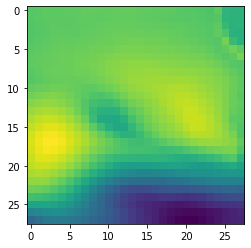

In [57]:
plt.imshow(X[1])

In [54]:
X = X.astype("float32")




In [52]:
Pres_n = (Pres-np.min(Pres))/(np.max(Pres)-np.min(Pres))



In [131]:
X = np.append(Pres,Gradiente,axis=1)  #al juntar presión con gradiente, desp tendrémos un problema para escalar, porque tienen valores muy distintos.
#X = Pres

Y = np.array(Hm0).reshape(-1,1)

#se pierde el indice, pero está guardado en Fechas.

In [53]:
X = Pres_n

In [55]:
X = np.expand_dims(X, -1)

In [56]:
Hm0 = np.array(df0[Desde: Hasta]['Hm0']).reshape(-1,1)
Tp = np.array(df0[Desde: Hasta]['Tp']).reshape(-1,1)
MD = np.array(df0[Desde: Hasta]['Mean Dir']).reshape(-1,1)
DSD =  np.array(df0[Desde: Hasta]['DSD']).reshape(-1,1)

In [11]:
'''
Preparamos los datos para modelar.
'''

def dividir3(X,Y, step):
    
    shape = X.shape
    X = X.reshape(shape[0],shape[1],shape[2],1)
    
    x = np.zeros([shape[0],shape[1],shape[2],step])

    for i in range(step,shape[0]):
        
        for j in range(step):
            
            x[i,:,:,j] =  X[i-j,:,:,0]
            

    return x[step:], Y[step:]


def get_set(X, Y, timestep, traslape):
    
    scx2 = MinMaxScaler([0,1])
    
    X_div, Y_div =  dividir2(X,scx2.fit_transform(Y), timestep, traslape)

    #X_div, Y_div =  X, scx2.fit_transform(Y)


    
    m = X_div.shape[0]

    x_train, x_test = X_div[:int(m*0.8)], X_div[int(m*0.8):]

    y_train, y_test = Y_div[:int(m*0.8)], Y_div[int(m*0.8):]

    print('X_train shape: ', x_train.shape)
    print('Y_train shape: ', y_train.shape)

    return x_train, x_test, y_train, y_test, scx2


def get_set2(X, Y, timestep, traslape):
    
    scx2 = MinMaxScaler([0,1])
    
    #X_div, Y_div =  dividir2(X,scx2.fit_transform(Y), timestep, traslape)

    X_div, Y_div =  dividir3(X, scx2.fit_transform(Y),traslape)


    
    m = X_div.shape[0]

    x_train, x_test = X_div[:int(m*0.8)], X_div[int(m*0.8):]

    y_train, y_test = Y_div[:int(m*0.8)], Y_div[int(m*0.8):]

    print('X_train shape: ', x_train.shape)
    print('Y_train shape: ', y_train.shape)

    return x_train, x_test, y_train, y_test, scx2

In [16]:
x_train, x_test, y_train, y_test, scy = get_set(X, Tp, timestep= 100, traslape = 100)

X_train shape:  (232, 200, 67, 80, 1)
Y_train shape:  (232, 100, 1)


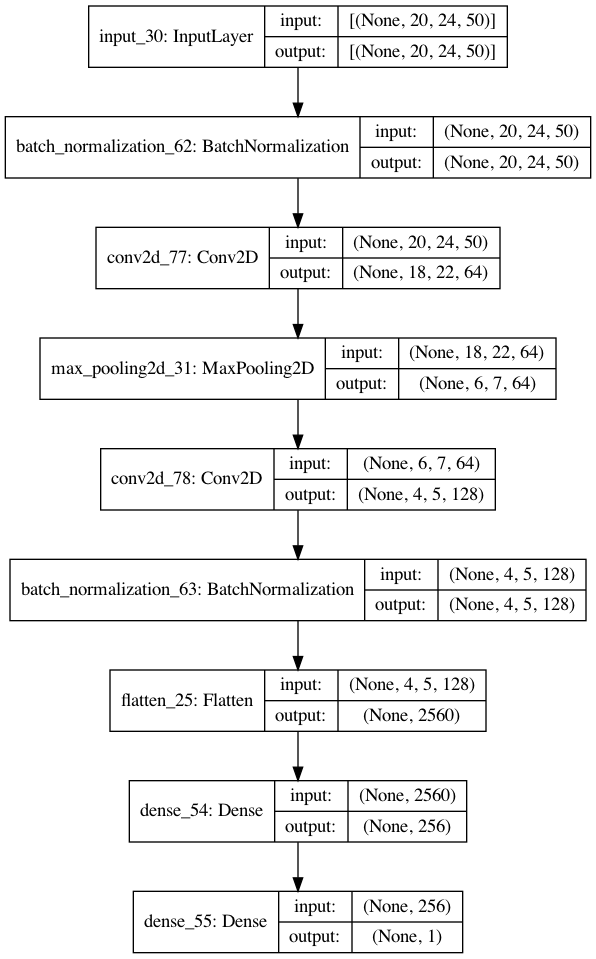

In [134]:
model = Sequential()

initializer = keras.initializers.RandomNormal(mean=0.1, stddev=1.)


model.add(Input(shape=( x_train.shape[1], x_train.shape[2], x_train.shape[3])))

model.add(BatchNormalization())

model.add((Conv2D(64, (3, 3), activation = 'relu')))

model.add(MaxPooling2D(3,3))

model.add((Conv2D(128, (3, 3),  activation = 'relu')))


model.add(BatchNormalization())

model.add((Flatten()))

model.add(Dense(256, activation = 'relu'))

model.add((Dense(1)))

model.compile(optimizer='adam',
              loss= 'mse' )

plot_model(model, show_shapes=True)

In [202]:
model = Sequential()

initializer = keras.initializers.RandomNormal(mean=0.1, stddev=1.)

initializer2 = keras.initializers.RandomNormal(mean=0.1, stddev=1.)



model.add(Input(shape=(None, x_train.shape[2], x_train.shape[3], 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu',kernel_initializer=initializer,bias_initializer=initializer)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((5, 5))))

#model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2, 2))))
#model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu')))

#model.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu')))

#model.add(TimeDistributed(Conv2D(1024, (3, 3), activation='relu')))
model.add(TimeDistributed(Flatten()))

model.add(TimeDistributed(Dense(256, activation='relu',kernel_initializer=initializer2,bias_initializer=initializer2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(BatchNormalization()))

model.add(LSTM(128,return_sequences = True))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Dense(128, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5), activation='relu',kernel_initializer=initializer2,bias_initializer=initializer2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam',
              loss= 'mse' )


In [63]:
input_img = keras.Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

encoded = Flatten()(x)

x = Reshape((7,7,128))(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0  

In [66]:
autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
)

Epoch 1/5
147/147 [==============================] - 55s 375ms/step - loss: 0.6048 - val_loss: 0.5990
Epoch 2/5
147/147 [==============================] - 56s 382ms/step - loss: 0.6047 - val_loss: 0.5991
Epoch 3/5
147/147 [==============================] - 56s 381ms/step - loss: 0.6048 - val_loss: 0.5999
Epoch 4/5
147/147 [==============================] - 57s 385ms/step - loss: 0.6048 - val_loss: 0.5991
Epoch 5/5
147/147 [==============================] - 56s 380ms/step - loss: 0.6047 - val_loss: 0.5991


In [68]:
y_pred = autoencoder.predict(x_test)

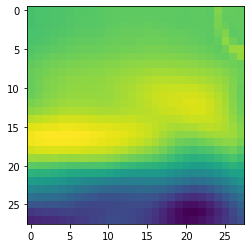

In [78]:
plt.imshow(y_pred[3000])

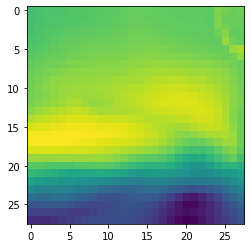

In [77]:
plt.imshow(x_test[3000])

In [104]:
encoder =  Model(input_img, encoded)
encoded_test = encoder.predict(x_test)

In [105]:
encoded_train = encoder.predict(x_train)

In [94]:
encode = encoded_img.reshape(encoded_img.shape[0],49,128)

In [103]:
encoded_img.shape

(5843, 6272)

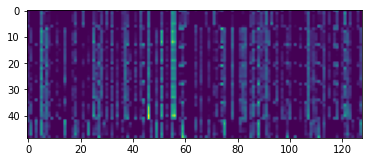

In [118]:
plt.imshow(encode[1100])

In [64]:
x_train, x_test, y_train, y_test, scy = get_set2(X[:30000], Tp[:30000], timestep= 300, traslape = 1)



X_train shape:  (23371, 28, 28, 1)
Y_train shape:  (23371, 1)


In [188]:
model.fit(x_train,y_train,epochs= 20,batch_size=2 ,validation_split=0.4, shuffle = True)

Epoch 1/20


ValueError: in user code:

    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_49 is incompatible with the layer: expected axis 3 of input shape to have value 50 but received input with shape (2, 20, 24, 40)


In [79]:
model.fit(x_train[:,1:],y_train,epochs= 5,batch_size=4 ,validation_split=0.2, shuffle = True)

Epoch 1/5
33/33 [==============================] - 39s 1s/step - loss: 1.1515 - val_loss: 0.2999
Epoch 2/5
33/33 [==============================] - 39s 1s/step - loss: 0.2943 - val_loss: 0.2328
Epoch 3/5
33/33 [==============================] - 38s 1s/step - loss: 0.2069 - val_loss: 0.1645
Epoch 4/5
33/33 [==============================] - 37s 1s/step - loss: 0.1727 - val_loss: 0.1344
Epoch 5/5
33/33 [==============================] - 37s 1s/step - loss: 0.1558 - val_loss: 0.1274


In [214]:


traslape = 1
ciclos = 1
for i in range(ciclos):
    print('Ciclo (',i+1,'/',ciclos,')')
    j = np.random.randint(-20,60)
    x_train, x_test, y_train, y_test, scy = get_set(X, Tp, timestep= int(j*10 +900), traslape = 1)
    #model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 15,batch_size=4 ,validation_split=0.1, shuffle = True)
    seq.fit(x_train[:,1:],y_train,epochs= 7,batch_size=4 ,validation_split=0.2, shuffle = True)
    seq.reset_states()
    

Ciclo ( 1 / 1 )
X_train shape:  (48, 1001, 20, 24, 1)
Y_train shape:  (48, 1000, 1)
Epoch 1/7
10/10 [==============================] - 384s 37s/step - loss: 8.0043 - val_loss: 6.5319
Epoch 2/7
10/10 [==============================] - 397s 40s/step - loss: 8.8941 - val_loss: 8.7680
Epoch 3/7
10/10 [==============================] - 379s 38s/step - loss: 8.8655 - val_loss: 8.7680
Epoch 4/7
10/10 [==============================] - 385s 38s/step - loss: 8.9039 - val_loss: 8.7375
Epoch 5/7
10/10 [==============================] - 374s 37s/step - loss: 8.8352 - val_loss: 8.7445
Epoch 6/7
10/10 [==============================] - 375s 38s/step - loss: 8.8290 - val_loss: 8.7532
Epoch 7/7
10/10 [==============================] - 375s 38s/step - loss: 8.9087 - val_loss: 8.7521


In [58]:
# Guardar el Modelo
model.save('/Users/javier/Documents/Código/Model_Tp_conv.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#model = keras.models.load_model('/Users/javier/Documents/Código/Model_Hm0.h5')

In [ ]:
from sklearn import linear_model

clf_t = linear_model.Ridge(alpha=.5,normalize=True)
clf_t = clf_t.fit(encoded_train,y_train)

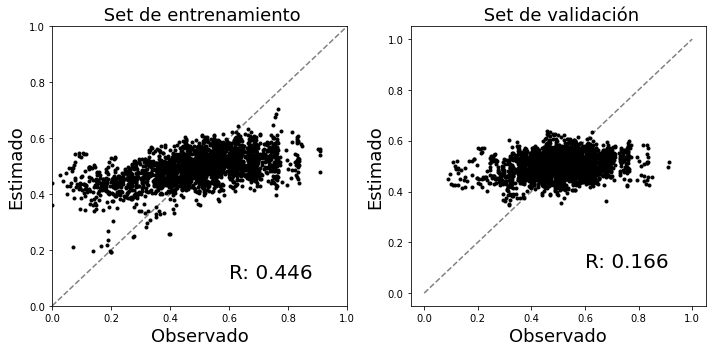

In [119]:
traslape =1



#y_pred_train = (autoencoder.predict(x_train))
#y_pred_test = (autoencoder.predict(x_test))


y_pred_train = clf_t.predict(encoded_train)
y_pred_test = clf_t.predict(encoded_test)


fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].set_title(' Set de entrenamiento',fontsize=18)
axs[0].plot([0,1],[0,1],'--',0.5,color='grey')
axs[0].plot(y_train[:3000],y_pred_train[:3000],'.',color='Black')
axs[0].set_xlabel('Observado',size=18)
axs[0].set_ylabel('Estimado',size=18)
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)
axs[0].text(0.6,0.1,'R: '+str(np.round(np.corrcoef(y_train.T,(y_pred_train).T)[0,1],3)),size=20)


axs[1].set_title(' Set de validación',fontsize=18)
axs[1].plot([0,1],[0,1],'--',0.5,color='grey')
axs[1].plot(y_test[:3000],y_pred_test[:3000],'.',color='Black')
axs[1].set_xlabel('Observado',size=18)
axs[1].set_ylabel('Estimado',size=18)
#axs[1].set_ylim(0,1)
#axs[1].set_xlim(0,1)
axs[1].text(0.6,0.1,'R: '+str(np.round(np.corrcoef(y_test.T,y_pred_test.T)[0,1],3)),size=20)

fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig("New_LSTM_Hm02",dpi=300)





In [112]:
y_pred_train = clf_t.predict(encoded_train)
y_pred_test = clf_t.predict(encoded_test)

In [114]:
np.round(np.corrcoef(y_train.T,y_pred_train.T)[0,1],3)

0.446

## Se corre un modelo para cada varíable de oleaje y se guardan los mejores ajustes del set de validación

In [255]:
Hm0_test = y_test
Hm0_pred = y_pred_test

In [183]:
Tp_test = y_test
Tp_pred = y_pred_test

In [222]:
MD_test = y_test
MD_pred = y_pred_test

In [237]:
DSD_test = y_test
DSD_pred = y_pred_test

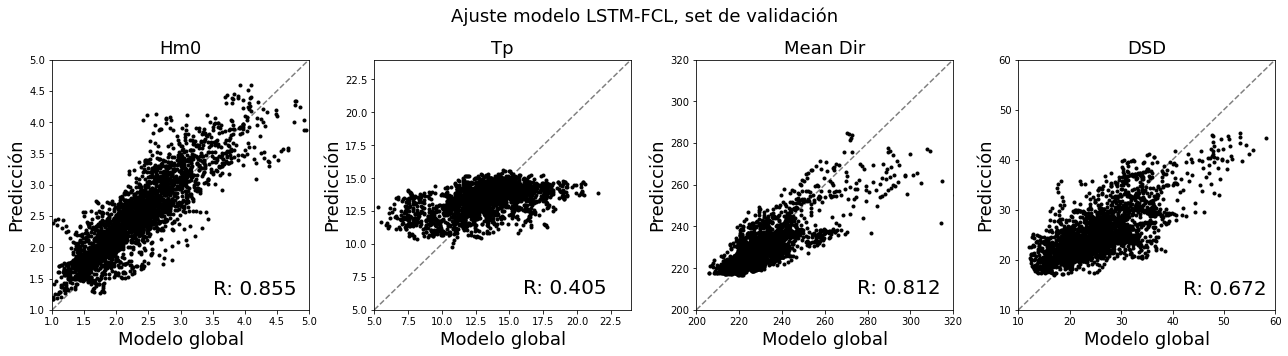

In [241]:
#y_pred = (juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

#y_test = (juntar(y_test))


fig, axs = plt.subplots(1, 4, figsize=(18,5))

fig.suptitle('Ajuste modelo LSTM-FCL, set de validación',fontsize=18)


axs[0].set_title('Hm0',fontsize=18)
axs[0].plot([1,5],[1,5],'--',0.5,color='grey')
axs[0].plot(Hm0_test[:3000,0],Hm0_pred[:3000,0],'.',color='Black')
axs[0].set_xlabel('Modelo global',size=18)
axs[0].set_ylabel('Predicción',size=18)
axs[0].set_ylim(1,5)
axs[0].set_xlim(1,5)
axs[0].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(Hm0_test.T,(Hm0_pred).T)[0,1],3)),size=20)


axs[1].set_title('Tp',fontsize=18)
axs[1].plot([5,24],[5,24],'--',0.5,color='grey')
axs[1].plot(Tp_test[:3000],Tp_pred[:3000],'.',color='Black')
axs[1].set_xlabel('Modelo global',size=18)
axs[1].set_ylabel('Predicción',size=18)
axs[1].set_ylim(5,24)
axs[1].set_xlim(5,24)
axs[1].text(16,6.2,'R: '+str(np.round(np.corrcoef(Tp_test.T,(Tp_pred).T)[0,1],3)),size=20)

axs[2].set_title('Mean Dir',fontsize=18)
axs[2].plot([200,320],[200,320],'--',0.5,color='grey')
axs[2].plot(MD_test[:3000],MD_pred[:3000],'.',color='Black')
axs[2].set_xlabel('Modelo global',size=18)
axs[2].set_ylabel('Predicción',size=18)
axs[2].set_ylim(200,320)
axs[2].set_xlim(200,320)
axs[2].text(275,208,'R: '+str(np.round(np.corrcoef(MD_test.T,(MD_pred).T)[0,1],3)),size=20)

axs[3].set_title('DSD',fontsize=18)
axs[3].plot([10,60],[10,60],'--',0.5,color='grey')
axs[3].plot(DSD_test[:3000],DSD_pred[:3000],'.',color='Black')
axs[3].set_xlabel('Modelo global',size=18)
axs[3].set_ylabel('Predicción',size=18)
axs[3].set_ylim(10,60)
axs[3].set_xlim(10,60)
axs[3].text(42,13,'R: '+str(np.round(np.corrcoef(DSD_test.T,(DSD_pred).T)[0,1],3)),size=20)






fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig("Variables_LSTM_2",dpi=300)

## Espectro de oleaje completo

In [21]:
import funciones as fn

def plot_espectro(data,i,j,time,ax,levels,cbar=False):

    deltaf= i[1]-i[0]
    f=[]
    for a in range(i.shape[0]):
        if deltaf<1:
            f.append(float(i[0] + a*deltaf))
        else:
            f.append(float(i[0]*deltaf**a))

    df = pd.DataFrame(columns = j, index = [1/freq for freq in f], 
                        data = data[time,:,:])

    return fn.plot_spectra(df, item = None, tstep = None, 
                 figsize = (4,4), cmap = 'viridis', cbar = cbar, cbar_label = None, 
                 levels = levels, ax = ax, extend = 'both',
                 watermark = None, prdw_logo_path = None, 
                 prdw_logo_size = [0.69, 0.75, 0.15, 0.15], 
                 prdw_logo_alpha = 0.5, fig = None)

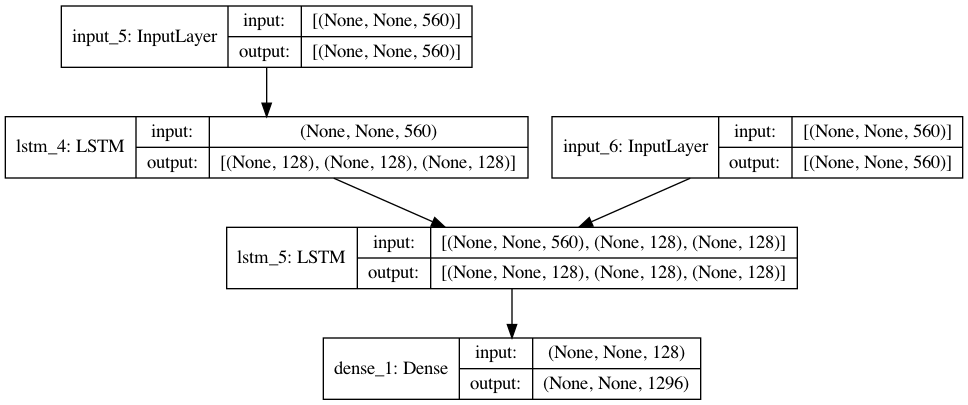

In [12]:
num_encoder_tokens = x_train.shape[2]
num_decoder_tokens = int(36*36)
hidden_units = 128

# Define an input sequence and process it.

encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder = LSTM(hidden_units, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.

decoder_inputs = Input(shape=(None, num_encoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

#decoder_dropout = Dropout(0.5)

#decoder_outputs = decoder_dropout(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens)

decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

plot_model(model, to_file='model.png', show_shapes=True)

In [14]:
path = '/Users/javier/Documents/Data/'
Espectro = xr.open_dataset(path + 'NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912.nc')

In [55]:
i = Espectro.i.data

j = Espectro.j.data

train_time = Espectro.Timestep.sel(Timestep = slice(Desde,Hasta)).data

Y = np.array(Espectro['Wave energy density'].sel(Timestep = slice(Desde,Hasta)))

Y = Y.reshape(Y.shape[0],Y.shape[1]*Y.shape[2])

In [19]:
traslape = 100

x_train, x_test, y_train, y_test, scy = get_set(X, Y, timestep= 1000, traslape = traslape)



X_train shape:  (72, 1100, 560)
Y_train shape:  (72, 1000, 1296)


In [20]:
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 35,batch_size=1 ,validation_split=0.1, shuffle = True)

Epoch 1/35
64/64 [==============================] - 22s 298ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 2/35
64/64 [==============================] - 19s 303ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 3/35
64/64 [==============================] - 20s 317ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/35
64/64 [==============================] - 20s 309ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/35
64/64 [==============================] - 20s 308ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 6/35
64/64 [==============================] - 20s 308ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/35
64/64 [==============================] - 20s 307ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/35
64/64 [==============================] - 20s 315ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/35
64/64 [==============================] - 23s 361ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/35
64/64 [==============================] - 20s 313ms/step - loss: 0.0026 - val_lo

In [27]:
y_train = juntar(y_train)
y_test = juntar(y_test)

In [32]:
y_test.shape

(18000, 36, 36)

In [31]:
juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])).shape

(18000, 1296)

In [34]:
y_test = scy.inverse_transform(y_test.reshape(y_test.shape[0],1296)).reshape(y_test.shape[0],36,36)
y_train = scy.inverse_transform(y_train.reshape(y_train.shape[0],1296)).reshape(y_train.shape[0],36,36)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))
y_pred_test = y_pred_test.reshape(y_pred_test.shape[0],36,36)

y_pred_train = scy.inverse_transform(juntar(model.predict([x_train[:,:traslape,:],x_train[:,traslape:,:]])))
y_pred_train = y_pred_train.reshape(y_pred_train.shape[0],36,36)

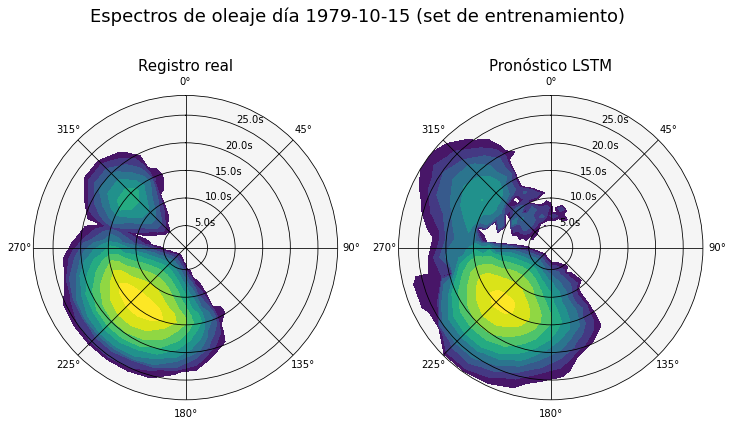

In [41]:
indice = 2300

levels = np.geomspace(0.01, 15, 10)


fig, axs = plt.subplots(1,2,figsize = (12,7), subplot_kw = dict(projection = 'polar'))#fig.suptitle('Vertically stacked subplots')

fig.suptitle('Espectros de oleaje día '+str(train_time[indice])[:10] + ' (set de entrenamiento)',fontsize=18)

plot_espectro(y_train,i,j,indice,axs[0],levels)

axs[0].set_title('Registro real',fontsize=15)

plot_espectro(np.round(y_pred_train,3),i,j,indice,axs[1],levels)

axs[1].set_title('Pronóstico LSTM',fontsize=15)

#plot_espectro(np.round(y_pred_train,3),i,j,indice,axs[2],levels)
#axs[2].set_title('Pronóstico LSTM-FCL',fontsize=15)



fig.set_facecolor('w')

fig.savefig("Espectro_trainset_LSTM_3",dpi=300)

In [42]:
from sklearn.metrics import mean_squared_error

MSE = []

for i in range(y_train.shape[0]):
    
    MSE.append(mean_squared_error(y_train[i], y_pred_train[i]))
    
MSE = np.array(MSE)



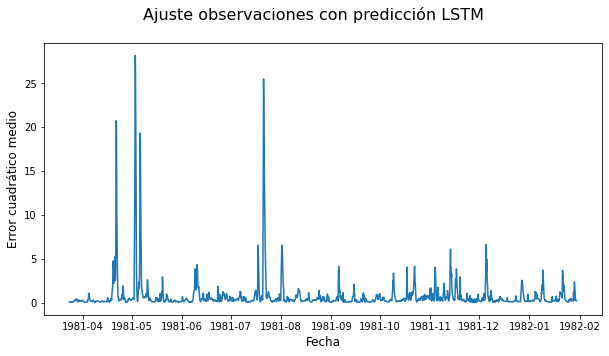

In [45]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(train_time[6500:9000],MSE[6500:9000])
fig.suptitle('Ajuste observaciones con predicción LSTM',fontsize=16)
ax.set_ylabel('Error cuadrático medio',fontsize=12)
ax.set_xlabel('Fecha',fontsize=12)
fig.set_facecolor('w')
fig.savefig('MSE_lstm', dpi=300)


In [86]:
train_time = train_time.reshape(-1,1)

tt = dividir(train_time[traslape:],1000)

tt = juntar(tt[int(0.8*tt.shape[0]):])


test_Hm0 = dividir(Hm0[traslape:],1000)

test_Hm0 = juntar(test_Hm0[int(0.8*test_Hm0.shape[0]):])

train_Hm0 = dividir(Hm0[traslape:],1000)

train_Hm0 = juntar(train_Hm0[:int(0.8*train_Hm0.shape[0])])

In [84]:
test_Hm0[1000]

I=i
J=j

In [81]:
dj = (J[2]-J[1])*2*np.pi/360   # delta j en rad
di = np.round((I[2]-I[1]),3)

In [96]:
y_train1 =y_train.reshape(-1,36*36)
y_test1 =y_test.reshape(-1,36*36)

In [95]:
from sklearn import linear_model

regresor = linear_model.Ridge(alpha=.5,normalize=True)
regresor = regresor.fit(y_train1,train_Hm0) 

In [83]:
u = np.round(y_test[1000],3)

In [97]:
pred_Hm0 = regresor.predict(y_test1)

In [99]:
pred_Hm0.shape

(18000, 1)

In [100]:
np.corrcoef(test_Hm0.T,pred_Hm0.T)

array([[1.       , 0.8587835],
       [0.8587835, 1.       ]])